# Convolutional Autoencoder

I have read some of the following sources as references for my code and implementation: 
https://2020machinelearning.medium.com/training-a-simple-autoencoder-on-the-mnist-dataset-a-hand-on-tutorial-46d8a024604c

https://2020machinelearning.medium.com/innovative-activation-functions-harnessing-the-power-of-pad%C3%A9-approximants-in-artificial-neural-e23387add554

https://www.reddit.com/r/MachineLearning/comments/jlzv8n/d_what_is_optimal_number_of_hidden_unit_in/

https://arxiv.org/abs/2006.08679



## Imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [2]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [17]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 20
NUM_CLASSES = 10

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [5]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.05)

In [6]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([1, 7, 6, 7, 5, 7, 4, 1, 1, 9])

Validation Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([9, 1, 8, 7, 0, 4, 7, 2, 0, 9])

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [7]:
# ##########################
# ### MODEL
# ##########################


# class Reshape(nn.Module):
#     def __init__(self, *args):
#         super().__init__()
#         self.shape = args

#     def forward(self, x):
#         return x.view(self.shape)


# class Trim(nn.Module):
#     def __init__(self, *args):
#         super().__init__()

#     def forward(self, x):
#         return x[:, :, :28, :28]


# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.encoder = nn.Sequential( #784
#                 nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
#                 nn.LeakyReLU(0.01),
#                 nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
#                 nn.LeakyReLU(0.01),
#                 nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
#                 nn.LeakyReLU(0.01),
#                 nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
#                 nn.Flatten(),
#                 nn.Linear(3136, 2)
#         )
#         self.decoder = nn.Sequential(
#                 torch.nn.Linear(2, 3136),
#                 Reshape(-1, 64, 7, 7),
#                 nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
#                 nn.LeakyReLU(0.01),
#                 nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
#                 nn.LeakyReLU(0.01),
#                 nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
#                 nn.LeakyReLU(0.01),
#                 nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
#                 Trim(),  # 1x29x29 -> 1x28x28
#                 nn.Sigmoid()
#                 )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [11]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.size(0), *self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 4, stride=(2, 2), kernel_size=(3, 3), padding=1), # 4x14x14
                nn.LeakyReLU(0.01),
                nn.Conv2d(4, 2, stride=(2, 2), kernel_size=(3, 3), padding=1), # 2x7x7
                nn.LeakyReLU(0.01),
                nn.Flatten(),
                nn.Linear(2*7*7, 8)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(8, 2*7*7),
                Reshape(2, 7, 7),
                nn.ConvTranspose2d(2, 4, stride=(2, 2), kernel_size=(3, 3), padding=1, output_padding=1), #4*14*14
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(4, 1, stride=(2, 2), kernel_size=(3, 3), padding=1, output_padding=1), #1*28*28         
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [12]:
set_all_seeds(RANDOM_SEED)

model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [13]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/020 | Batch 0000/1781 | Loss: 0.2309
Epoch: 001/020 | Batch 0250/1781 | Loss: 0.0796
Epoch: 001/020 | Batch 0500/1781 | Loss: 0.0733
Epoch: 001/020 | Batch 0750/1781 | Loss: 0.0656
Epoch: 001/020 | Batch 1000/1781 | Loss: 0.0536
Epoch: 001/020 | Batch 1250/1781 | Loss: 0.0545
Epoch: 001/020 | Batch 1500/1781 | Loss: 0.0478
Epoch: 001/020 | Batch 1750/1781 | Loss: 0.0468
Time elapsed: 0.26 min
Epoch: 002/020 | Batch 0000/1781 | Loss: 0.0426
Epoch: 002/020 | Batch 0250/1781 | Loss: 0.0458
Epoch: 002/020 | Batch 0500/1781 | Loss: 0.0429
Epoch: 002/020 | Batch 0750/1781 | Loss: 0.0421
Epoch: 002/020 | Batch 1000/1781 | Loss: 0.0429
Epoch: 002/020 | Batch 1250/1781 | Loss: 0.0440
Epoch: 002/020 | Batch 1500/1781 | Loss: 0.0374
Epoch: 002/020 | Batch 1750/1781 | Loss: 0.0420
Time elapsed: 0.49 min
Epoch: 003/020 | Batch 0000/1781 | Loss: 0.0410
Epoch: 003/020 | Batch 0250/1781 | Loss: 0.0380
Epoch: 003/020 | Batch 0500/1781 | Loss: 0.0401
Epoch: 003/020 | Batch 0750/1781 | Loss: 0

## Evaluation

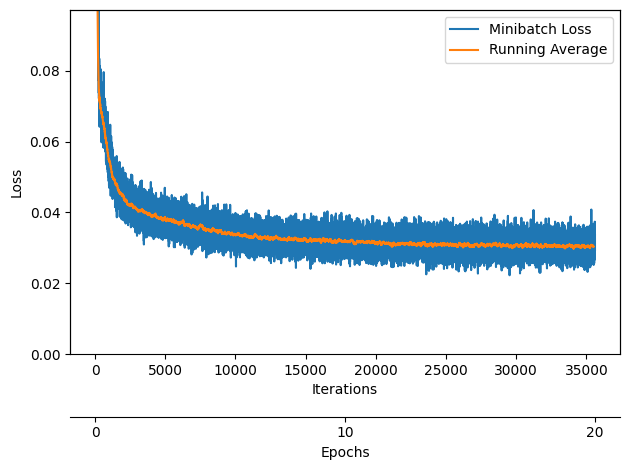

In [14]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

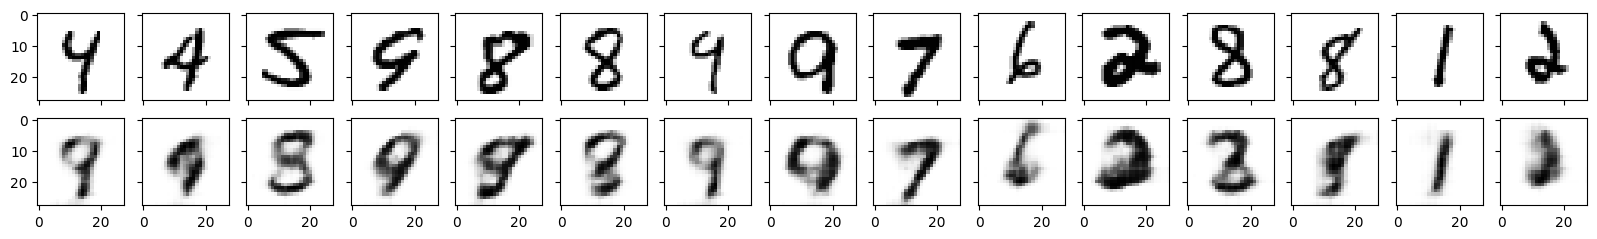

In [15]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)           

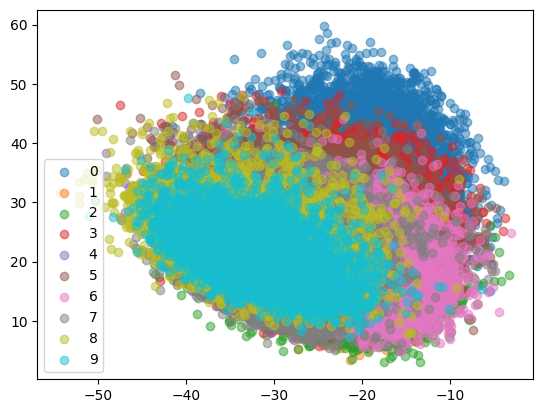

In [18]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model, 
    device=DEVICE)

plt.legend()
plt.show()

In [19]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.5, -2.5]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 8x98)